In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer, Dropout,MaxPooling2D,GlobalAveragePooling2D,Activation,Add,LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import InputLayer,Dense,Conv2D,MaxPool2D,Flatten,BatchNormalization,Input,RandomFlip, RandomRotation, Resizing, Rescaling,RandomContrast
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TrueNegatives, TruePositives, Precision, Recall, AUC, CategoricalAccuracy,TopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy,SparseCategoricalCrossentropy
import  cv2

In [ ]:
dataset_dir = "/content/drive/MyDrive/Datasets/planet_dataset"
CONFIG = {
    "BATCH_SIZE" : 32,
    "IM_SIZE" : 256,
}

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    shuffle=True,
    image_size=(CONFIG["IM_SIZE"],CONFIG["IM_SIZE"]),
    batch_size=CONFIG["BATCH_SIZE"],
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
def get_dataset_partitions_tf(ds,train_split = 0.8,val_split=0.1,test_split=0.1,shuffle =True,shuffle_size =10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=123)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
print(f"Train Size: {len(train_ds)},Test Size: {len(test_ds)},Val Size: {len(val_ds)}")

Train Size: 54,Test Size: 8,Val Size: 6


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
print(train_ds)
print(val_ds)
print(test_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


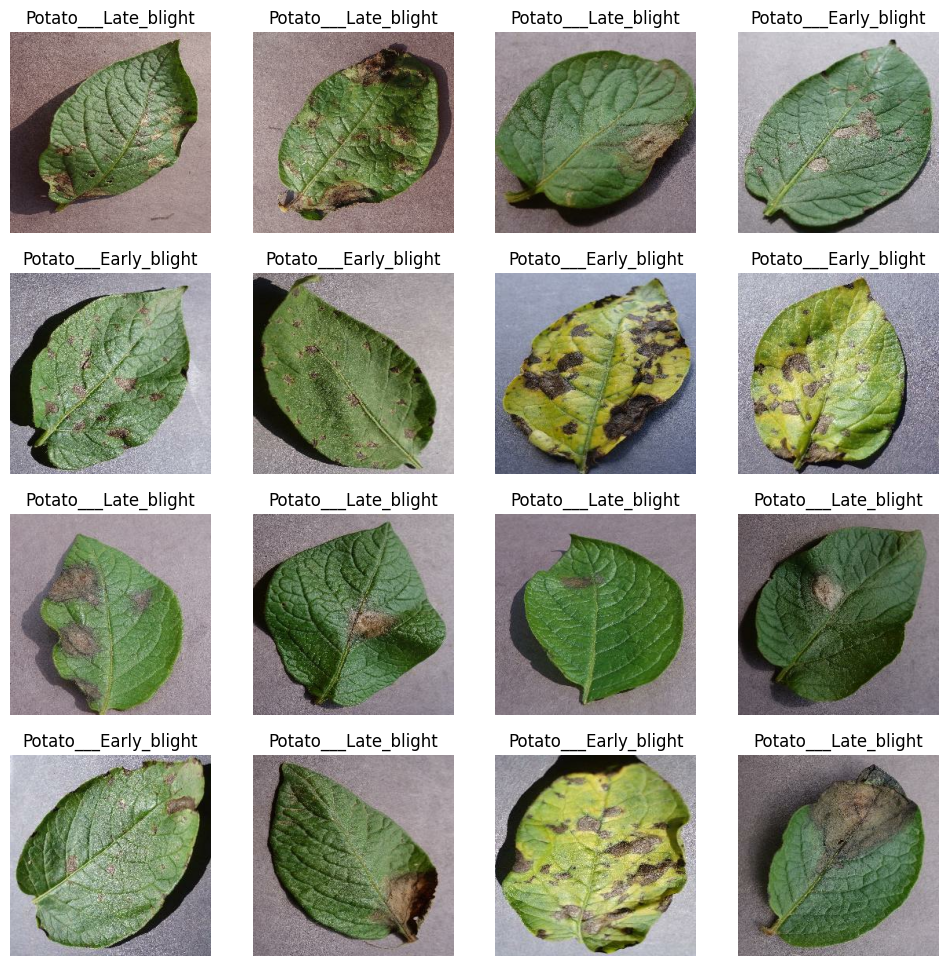

In [ ]:
plt.figure(figsize=(12,12))

for images,labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255.)
    plt.title(class_names[labels[i].numpy()])
    #plt.title(class_names[tf.argmax(labels[i],axis=0).numpy()])
    plt.axis("off")

In [ ]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    InputLayer(input_shape = (CONFIG["IM_SIZE"],CONFIG["IM_SIZE"],3)),
    Rescaling(1./255,name = "rescaling"),

    Conv2D(filters = 16, kernel_size = 3, strides = 1,padding="valid", activation = 'relu'),
    MaxPooling2D(),
    Conv2D(filters = 32, kernel_size = 3, strides = 1,padding="valid", activation = 'relu'),
    MaxPooling2D(),
    Conv2D(filters = 64, kernel_size = 3, strides = 1,padding="valid", activation = 'relu'),
    MaxPooling2D(),

    Flatten(),

    Dense(128, activation='relu'),
    Dense(num_classes, activation = "softmax")
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        1

In [ ]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(train_ds,validation_data = val_ds, epochs = 10, verbose = 1, batch_size = CONFIG["BATCH_SIZE"])

Epoch 1/10
54/54 [==============================] - 139s 129ms/step - loss: 0.8296 - accuracy: 0.7148 - val_loss: 0.4630 - val_accuracy: 0.8229
Epoch 2/10
54/54 [==============================] - 2s 36ms/step - loss: 0.3037 - accuracy: 0.8797 - val_loss: 0.1733 - val_accuracy: 0.9323
Epoch 3/10
54/54 [==============================] - 2s 35ms/step - loss: 0.1807 - accuracy: 0.9401 - val_loss: 0.1277 - val_accuracy: 0.9479
Epoch 4/10
54/54 [==============================] - 2s 35ms/step - loss: 0.0908 - accuracy: 0.9619 - val_loss: 0.1286 - val_accuracy: 0.9375
Epoch 5/10
54/54 [==============================] - 2s 36ms/step - loss: 0.0513 - accuracy: 0.9830 - val_loss: 0.0490 - val_accuracy: 0.9740
Epoch 6/10
54/54 [==============================] - 2s 38ms/step - loss: 0.0427 - accuracy: 0.9859 - val_loss: 0.0950 - val_accuracy: 0.9688
Epoch 7/10
54/54 [==============================] - 2s 36ms/step - loss: 0.1527 - accuracy: 0.9401 - val_loss: 0.0829 - val_accuracy: 0.9635
Epoch 8/10

In [ ]:
model.evaluate(test_ds)

8/8 [==============================] - 4s 19ms/step - loss: 0.0020 - accuracy: 1.0000


[0.0020338676404207945, 1.0]

In [ ]:
model.save("plants.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Models/plants.h5")

1/1 [==============================] - 0s 22ms/step


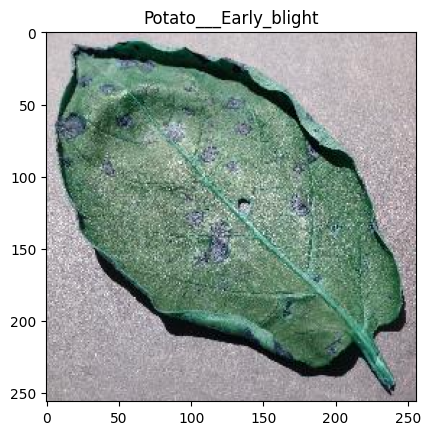

In [ ]:
labels = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

test_img = cv2.imread("/content/drive/MyDrive/Datasets/planet_dataset/Potato___Early_blight/009c8c31-f22d-4ffd-8f16-189c6f06c577___RS_Early.B 7885.JPG")
test_img = cv2.resize(test_img,(256,256),cv2.INTER_LINEAR)

img_array = tf.keras.preprocessing.image.img_to_array(test_img)
img_array = tf.expand_dims(img_array,axis = 0)

prediction = model.predict(img_array)
plt.title(labels[np.argmax(prediction)])

plt.imshow(test_img)
plt.show()
